# **Audio Watermarking with CNN**

## Dataset Download

In [1]:
## Preprocessed datasets
## Audio sampling @ 8192 Hz
## Images rescaled @ 128 x 128
!gdown --id 1YrQQ9iDqcANDR3SfonyVlzLX1YCunWYC
!gdown --id 1osCyCUhoPfuvD1l_mCYYD3lTsYxGdY7m
!gdown --id 1r22ZTwQ8R-8VXexsuFxWXbVQm8Wyw_Y3

Downloading...
From: https://drive.google.com/uc?id=1YrQQ9iDqcANDR3SfonyVlzLX1YCunWYC
To: /content/waves.npy
707MB [00:10, 67.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1osCyCUhoPfuvD1l_mCYYD3lTsYxGdY7m
To: /content/labels.npy
100% 431k/431k [00:00<00:00, 6.75MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r22ZTwQ8R-8VXexsuFxWXbVQm8Wyw_Y3
To: /content/img_dataset.npy
246MB [00:02, 85.0MB/s]


In [2]:
import librosa
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tqdm.auto import tqdm, trange
tf.random.set_seed(314)
np.random.seed(999)

In [3]:
class Encoder(tf.keras.Model):
  def __init__(self):

    """
      Expects input shape of (None, 8192, 1)
    """

    super(Encoder, self).__init__()

    self.audio_encoder_model = tf.keras.Sequential(name='Encoder')
    self.audio_encoder_model.add(layers.Conv1D(8,3, activation='relu', padding='same',dilation_rate=2))
    self.audio_encoder_model.add(layers.MaxPooling1D(2))
    self.audio_encoder_model.add(layers.Conv1D(4,3, activation='relu', padding='same',dilation_rate=2))
    self.audio_encoder_model.add(layers.MaxPooling1D(2))
    self.audio_encoder_model.add(layers.Conv1D(48,3, activation='relu', padding='same'))
    self.audio_encoder_model.add(layers.AveragePooling1D())

  def call(self, input_audio):
    out = self.audio_encoder_model(input_audio)
    return out

class Decoder(tf.keras.Model):
  def __init__(self):

    """
      Expects feature shape of (None, 1048, 48)
    """

    super(Decoder, self).__init__()

    self.audio_decoder_model = tf.keras.Sequential(name='Decoder')

    self.audio_decoder_model.add(layers.Conv1D(24,1,strides=1, activation='relu', padding='same'))
    self.audio_decoder_model.add(layers.UpSampling1D(2))
    self.audio_decoder_model.add(layers.Conv1D(4,1,strides=1, activation='relu', padding='same'))
    self.audio_decoder_model.add(layers.UpSampling1D(2))
    self.audio_decoder_model.add(layers.Conv1D(8,1,strides=1, activation='relu', padding='same'))
    self.audio_decoder_model.add(layers.UpSampling1D(2))
    # self.audio_decoder_model.add(layers.UpSampling1D(2))
    self.audio_decoder_model.add(layers.Conv1D(1,1,strides=1, activation='tanh', padding='same'))

  def call(self, encoded_feature_input):
    out = self.audio_decoder_model(encoded_feature_input)
    return out

In [4]:
class Embedder(tf.keras.Model):
  def __init__(self):

    """
      Expects feature shape of (None, 1048, 48)
    """

    super(Embedder, self).__init__()

    self.pre_concat = layers.Conv2D(3, 1, activation='relu', padding='same')
    self.concat_l = layers.Concatenate()

    self.embedder = tf.keras.Sequential(name='Embedder')
    self.embedder.add(layers.Conv2D(6, 1, activation='relu', padding='same'))
    self.embedder.add(layers.Conv2D(6, 3, activation='relu', padding='same'))
    self.embedder.add(layers.Dropout(0.5))
    self.embedder.add(layers.Conv2D(3, 1, activation='sigmoid', padding='same'))

  def call(self, encoded_feature_input, cover):
    out = self.pre_concat(encoded_feature_input)
    out = self.concat_l([cover, out])
    out = self.embedder(out)
    return out

class Extractor(tf.keras.Model):
  def __init__(self):

    """
      Expects feature shape of (None, 1048, 48)
    """

    super(Extractor, self).__init__()

    self.extractor = tf.keras.Sequential(name='Extractor')

    self.extractor.add(layers.Conv2D(3, 1, activation='relu', padding='same'))
    self.extractor.add(layers.Conv2D(6, 1, activation='relu', padding='same'))
    self.extractor.add(layers.Conv2D(6, 3, activation='relu', padding='same'))
    self.extractor.add(layers.Conv2D(3, 1, activation='relu', padding='same'))

  def call(self, marked_img):
    out = self.extractor(marked_img)
    return out

In [5]:
ip = Input(shape=(128, 128, 3))
x = layers.Conv2D(3, 1, activation='relu', padding='same')(ip)
x = layers.Concatenate()([x, ip])
x = layers.Conv2D(6, 1, activation='relu', padding='same')(x)
x = layers.Conv2D(6, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(3, 1, activation='relu', padding='same')(x)
m = Model(ip, x)
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 6)  0           conv2d[0][0]                     
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 6)  42          concatenate[0][0]            

In [6]:
model = Encoder()
model.build(input_shape=(None, 8192, 1))
model.summary()

model = Decoder()
model.build(input_shape=(None, 1024, 4))
model.summary()

model = Extractor()
model.build(input_shape=(None, 128, 128, 3))
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Sequential)         (None, 1024, 48)          756       
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder (Sequential)         (None, 8192, 1)           269       
Total params: 269
Trainable params: 269
Non-trainable params: 0
_________________________________________________________________
Model: "extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Extractor (Sequential)       (None, 128, 128, 3)       387       
Total params: 387
Trainable params: 387
Non-trainable params: 0
_____________________________

In [7]:
class DataGenerator(object):
  def __init__(self, batch_size=32):
    self.batch_size = batch_size
    self.audio_data = np.load('waves.npy')
    np.random.shuffle(self.audio_data)
    self.img_data = np.load('img_dataset.npy')
    self.img_data = self.img_data.astype(np.float32) / 255.0
    np.random.shuffle(self.img_data)
  
  def sample_batch(self):
    img_batch = np.random.choice(self.img_data.shape[0], self.batch_size, replace=False)
    img_batch = self.img_data[img_batch]
    audio_batch = np.random.choice(self.audio_data.shape[0], self.batch_size, replace=False)
    audio_batch = self.audio_data[audio_batch]
    return img_batch, audio_batch

In [8]:
generator = DataGenerator()

In [9]:
class Steno(tf.keras.Model):    ## Putting all blocks together
  def __init__(self):
    super(Steno, self).__init__()
    self.encoder = Encoder()
    self.reshape1 = layers.Reshape((128, 128, 3))
    self.reshape2 = layers.Reshape((1024, 48))
    self.embedder = Embedder()
    self.extractor = Extractor()
    self.decoder = Decoder()

  def call(self, batch_audio, batch_image):
    enc = self.encoder(batch_audio)
    out = self.reshape1(enc)
    marked = self.embedder(out, batch_image)
    out = self.extractor(marked)
    out = self.reshape2(out)
    out = self.decoder(out)
    return out, enc, marked
  
  def loss_function(self, pred, orig_audio, marked=None, orig_img=None):
    return 100*tf.reduce_mean(tf.keras.losses.mean_squared_error(orig_audio, pred)) + 10*tf.reduce_mean(tf.keras.losses.mean_squared_error(orig_img, marked))

In [10]:
@tf.function
def train_step(audios, images, model, optim):
  with tf.GradientTape() as tape:
      predictions, enc, marked = model(audios, images)
      loss = model.loss_function(predictions, audios, marked, images)
      gradients = tape.gradient(loss, model.trainable_variables)
      optim.apply_gradients(zip(gradients, model.trainable_variables))
  return predictions, loss

In [11]:
t = trange(5000)
losses = []
idx = 0
min_loss = 999
with tf.device('/gpu:0'):
  optim = tf.keras.optimizers.Adam(learning_rate=0.001)
  o = Steno()
for step in t:
  i, a = generator.sample_batch()
  p, ls = train_step(a, i, o, optim)
  losses.append(ls.numpy())
  if ls.numpy() < min_loss:
    min_loss = ls.numpy()
    idx = step
  t.set_postfix_str(s=f'loss: {ls.numpy():.5f}')

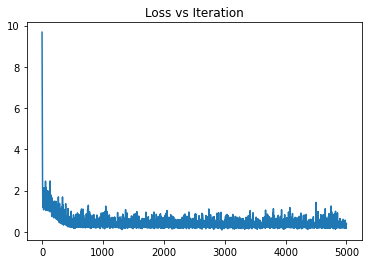

In [12]:
plt.title('Loss vs Iteration')
plt.plot(losses)

In [13]:
min_loss, idx

(0.09558925, 2953)

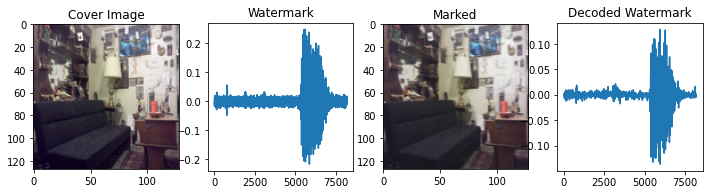

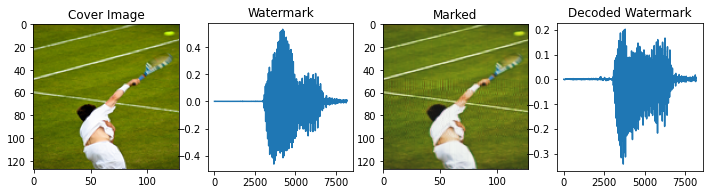

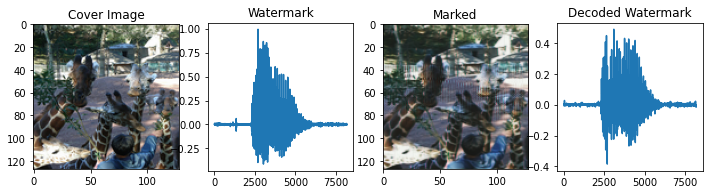

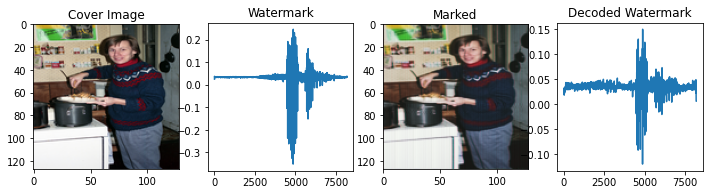

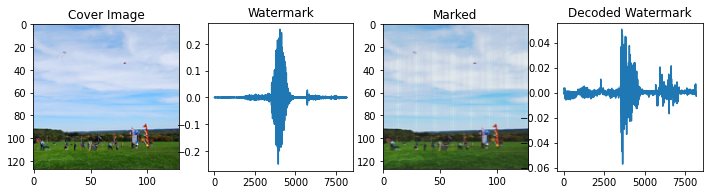

In [14]:
imgs, audios = generator.sample_batch()
preds, enc, marked = o(audios, imgs)

for i in range(5):
  fig = plt.figure(figsize=(12, 6))

  fig.add_subplot(241)
  plt.title('Cover Image')
  plt.imshow(imgs[i])

  fig.add_subplot(242)
  plt.title('Watermark')
  plt.plot(audios[i])

  fig.add_subplot(243)
  plt.title('Marked')
  plt.imshow(marked[i])

  fig.add_subplot(244)
  plt.title('Decoded Watermark')
  plt.plot(preds[i])